/tmp/ipython-input-2847654034.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipython-input-2847654034.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean().interpolate()


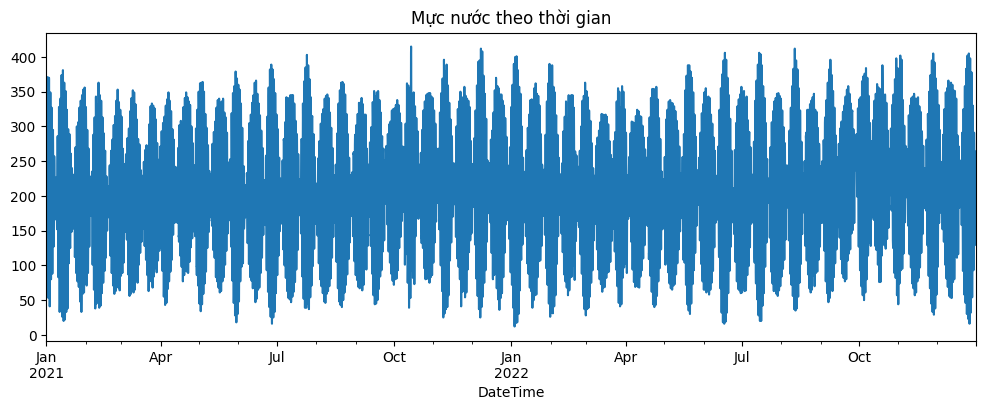

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv(
    "dulieudachuanhoa (1).csv",
    parse_dates=["DateTime"],           # cột cần parse
    date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%Y %H:%M")  # hoặc "%m/%d/%y %H:%M"
)

df = df.set_index("DateTime")

# Kiểm tra & sắp xếp
df = df.sort_index()

# (Tùy chọn) Nếu dữ liệu chưa liên tục theo giờ, resample:
df = df.resample("1H").mean().interpolate()

# Vẽ nhanh để hình dung
df["Value(cm)"].plot(figsize=(12,4), title="Mực nước theo thời gian")
plt.show()


In [ ]:
# Chuẩn hoá về [0,1] để GRU học dễ hơn
scaler = MinMaxScaler(feature_range=(0,1))
values_scaled = scaler.fit_transform(df[["Value(cm)"]].values)

# Hàm tạo cặp (X, y) dựa trên cửa sổ trượt
def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 24*7   # số giờ quá khứ để dự đoán giờ kế tiếp
X, y = create_sequences(values_scaled, LOOK_BACK)

# Thêm chiều features cho Keras: (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

# Tách train/test (80-20)
split = int(0.8 * len(X))
X_train, X_test  = X[:split],  X[split:]
y_train, y_test  = y[:split],  y[split:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

tf.random.set_seed(42)

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(LOOK_BACK, 1)),
    Dropout(0.2),
    GRU(32),
    Dense(1)         # đầu ra đơn lẻ
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 168, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0172 - mae: 0.0861 - val_loss: 4.1526e-04 - val_mae: 0.0159
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 9.1012e-04 - mae: 0.0238 - val_loss: 3.5097e-04 - val_mae: 0.0153
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 6.1194e-04 - mae: 0.0196 - val_loss: 3.1306e-04 - val_mae: 0.0144
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.7581e-04 - mae: 0.0172 - val_loss: 2.5125e-04 - val_mae: 0.0124
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4.0274e-04 - mae: 0.0158 - val_loss: 3.8196e-04 - val_mae: 0.0161
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.6496e-04 - mae: 0.0151 - val_loss: 2.9623e-04 - val_mae: 0.0140
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.9542e-04 - mae: 0.0136 - val_loss: 1.7582e-04 - val_mae: 0.0103
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.7610e-04 - mae: 0.0132 - val_loss: 1.5651e-

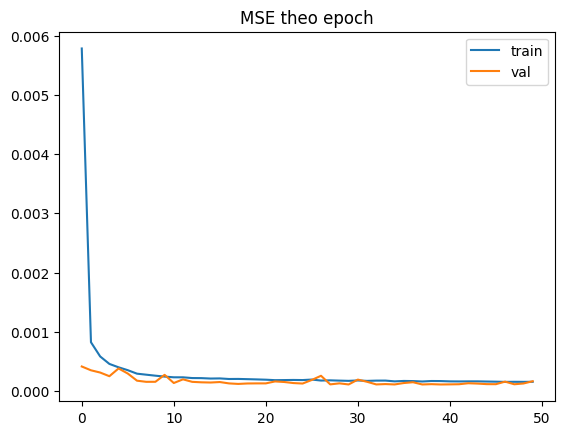

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend(); plt.title("MSE theo epoch"); plt.show()


In [ ]:
def forecast_future(model, last_window, n_steps):
    """last_window: (look_back,1) đã scale"""
    preds = []
    current_input = last_window.copy()
    for _ in range(n_steps):
        pred = model.predict(current_input[np.newaxis, ...])[0,0]
        preds.append(pred)
        # cập nhật cửa sổ
        current_input = np.roll(current_input, -1)
        current_input[-1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1))

# Lấy cửa sổ cuối cùng của toàn bộ dữ liệu
last_window = values_scaled[-LOOK_BACK:]
future_24h  = forecast_future(model, last_window, n_steps=24)
print("Dự đoán 24 giờ tới (cm):\n", future_24h.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Dự đoán 24 giờ tới (cm):
 [173.30865 176.06802 180.62592 187.87349 197.66324 208.74428 

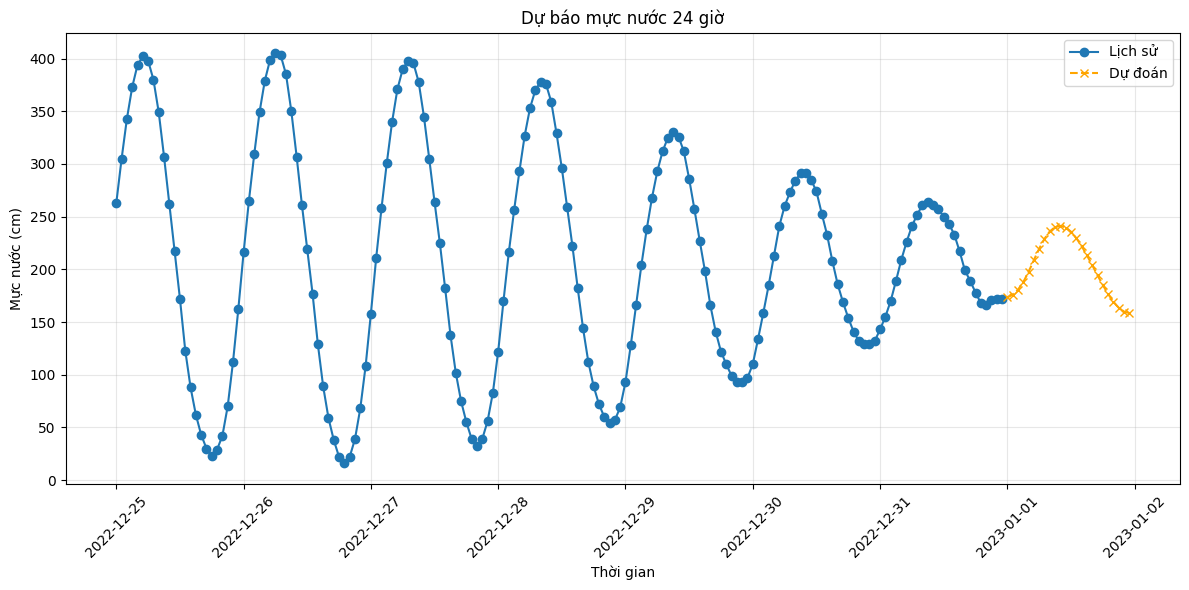

In [ ]:

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Tạo timeline
last_date = df.index[-1]
future_dates = [last_date + timedelta(hours=i+1) for i in range(24)]

plt.figure(figsize=(12, 6))

# Vẽ dữ liệu lịch sử
plt.plot(df.index[-24*7:], df['Value(cm)'][-24*7:], label='Lịch sử', marker='o')

# Vẽ dự đoán
plt.plot(future_dates, future_24h.flatten(), label='Dự đoán',
         color='orange', linestyle='--', marker='x')

plt.title('Dự báo mực nước 24 giờ')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (cm)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model.save("gru_waterlevel_model.keras")
import joblib
joblib.dump(scaler, "scaler.save")

['scaler.save']

In [ ]:
import numpy as np

def forecast_future(model, last_window, n_steps, scaler):
    """
    model       : mô hình (đã huấn luyện).
    last_window : mảng shape = (look_back, 1) – đã scale.
    n_steps     : số bước dự báo tương lai.
    scaler      : đối tượng scaler dùng lúc tiền xử lý.
    """
    preds = []
    current_input = last_window.copy()

    for _ in range(n_steps):
        # model dự đoán cho 1 bước
        pred = model.predict(current_input[np.newaxis, ...], verbose=0)[0, 0]
        preds.append(pred)

        # trượt cửa sổ: bỏ giá trị đầu, thêm giá trị mới vào cuối
        current_input = np.roll(current_input, -1)
        current_input[-1, 0] = pred

    # đảo scale về đơn vị gốc
    preds_original = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds_original


In [ ]:
def forecast_at(model, data_scaled, data_original, t_index, look_back,
                n_steps, scaler):
    """
    data_scaled    : chuỗi sau khi scale, shape = (N, 1)
    data_original  : chuỗi gốc (chưa scale), shape = (N, )
    t_index        : chỉ số thời gian muốn bắt đầu dự báo (0-based)
    """
    # Bảo đảm đủ dữ liệu quá khứ
    if t_index < look_back:
        raise ValueError("t_index phải ≥ look_back")

    # Lấy cửa sổ look_back bước trước thời điểm t
    window = data_scaled[t_index - look_back : t_index]

    # Dự báo 24 giờ tới
    preds = forecast_future(model, window, n_steps, scaler)

    # Lấy dữ liệu thực cùng khung thời gian để so sánh
    actual = data_original[t_index : t_index + n_steps]

    return preds, actual


In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(preds, actual, start_time=None, ylabel="Giá trị"):
    """
    start_time : chỉ để hiển thị trên trục x (tuple hoặc số, tuỳ bạn)
    """
    horizon = np.arange(len(preds))

    plt.figure(figsize=(10, 4))
    plt.plot(horizon, actual, label="Thực tế", linewidth=2)
    plt.plot(horizon, preds,  label="Dự báo",  linewidth=2, linestyle="--")
    plt.title("So sánh dự báo 24 giờ và dữ liệu thực")
    plt.xlabel("Giờ tới" if start_time is None else f"Ghế {start_time}+h")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


RMSE 24 giờ tại mốc t=5500: 16.031


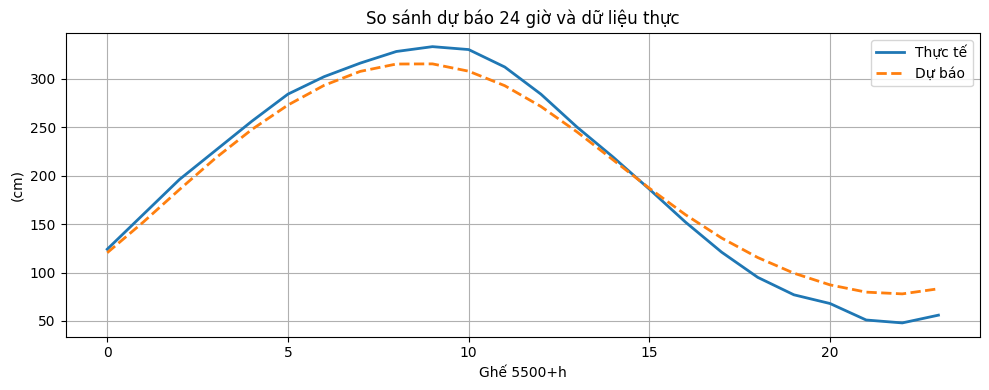

In [ ]:
LOOK_BACK = 48          # ví dụ: sử dụng 48 bước (≈ 2 ngày) làm đầu vào
N_STEPS   = 24          # dự báo 24 giờ
t = 5500                # chọn mốc thời gian bất kỳ

# Chuẩn bị dữ liệu (giả sử bạn đã có):
# - values_scaled : ndarray (N,1)
# - values        : ndarray (N, )
# - scaler        : đối tượng MinMaxScaler / StandardScaler…
# - model         : mô hình đã train

# Extract the original 'Value(cm)' data from the DataFrame
values = df['Value(cm)'].values

preds_24h, actual_24h = forecast_at(model,
                                    data_scaled   = values_scaled,
                                    data_original = values,
                                    t_index       = t,
                                    look_back     = LOOK_BACK,
                                    n_steps       = N_STEPS,
                                    scaler        = scaler)

# Tính RMSE nhanh (tùy chọn)
rmse = np.sqrt(np.mean((preds_24h - actual_24h) ** 2))
print(f"RMSE 24 giờ tại mốc t={t}: {rmse:.3f}")

# Vẽ
plot_forecast(preds_24h, actual_24h, start_time=t, ylabel="(cm)")

In [ ]:
from datetime import datetime, timedelta
import pytz

# Lấy giờ hiện tại theo múi giờ Việt Nam
tz_vn = pytz.timezone("Asia/Ho_Chi_Minh")
now = datetime.now(tz_vn)

# Dự đoán
n_hours = 720
last_window = values_scaled[-LOOK_BACK:]
future_10h = forecast_future(model, last_window, n_steps=n_hours, scaler=scaler)
future_times = [now + timedelta(hours=i+1) for i in range(n_hours)]

# In kết quả
print("Dự báo mực nước 10 giờ tiếp theo (giờ Việt Nam):")
for time, value in zip(future_times, future_10h):
    print(f"{time.strftime('%Y-%m-%d %H:%M')} → {value:.2f} cm")


Dự báo mực nước 10 giờ tiếp theo (giờ Việt Nam):
2025-10-18 20:29 → 173.31 cm
2025-10-18 21:29 → 176.07 cm
2025-10-18 22:29 → 180.63 cm
2025-10-18 23:29 → 187.88 cm
2025-10-19 00:29 → 197.67 cm
2025-10-19 01:29 → 208.75 cm
2025-10-19 02:29 → 219.65 cm
2025-10-19 03:29 → 229.04 cm
2025-10-19 04:29 → 236.02 cm
2025-10-19 05:29 → 240.15 cm
2025-10-19 06:29 → 241.34 cm
2025-10-19 07:29 → 239.78 cm
2025-10-19 08:29 → 235.78 cm
2025-10-19 09:29 → 229.76 cm
2025-10-19 10:29 → 222.16 cm
2025-10-19 11:29 → 213.44 cm
2025-10-19 12:29 → 204.07 cm
2025-10-19 13:29 → 194.49 cm
2025-10-19 14:29 → 185.19 cm
2025-10-19 15:29 → 176.63 cm
2025-10-19 16:29 → 169.29 cm
2025-10-19 17:29 → 163.60 cm
2025-10-19 18:29 → 159.92 cm
2025-10-19 19:29 → 158.54 cm
2025-10-19 20:29 → 159.59 cm
2025-10-19 21:29 → 163.09 cm
2025-10-19 22:29 → 168.85 cm
2025-10-19 23:29 → 176.55 cm
2025-10-20 00:29 → 185.71 cm
2025-10-20 01:29 → 195.75 cm
2025-10-20 02:29 → 206.03 cm
2025-10-20 03:29 → 215.89 cm
2025-10-20 04:29 → 224.

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import pytz

# ==== CẤU HÌNH GOOGLE SHEET ====
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name(
    "calcium-doodad-466807-m5-96172eff2ccd.json", scope
)
client = gspread.authorize(creds)

# Mở file Google Sheet của bạn
spreadsheet = client.open_by_key("1x4rokcl_kx6N8INXb-izgOyGJAJuwMtS3Fle1FlgEQw")
sheet = spreadsheet.sheet1  # sheet đầu tiên

# ==== DỰ BÁO 720 GIỜ (giữ phần tính toán của bạn) ====
tz_vn = pytz.timezone("Asia/Ho_Chi_Minh")
now = datetime.now(tz_vn)
n_hours = 720  # 30 ngày tới
last_window = values_scaled[-LOOK_BACK:]  # dữ liệu cuối
future_720h = forecast_future(model, last_window, n_steps=n_hours, scaler=scaler)

# Tạo danh sách thời gian theo múi giờ Việt Nam
future_times = [now + timedelta(hours=i + 1) for i in range(n_hours)]

# ==== CHÈN TIẾP VÀO CỘT A (Thời gian) VÀ CỘT C (Mực nước) ====
fmt = "%Y-%m-%d %H:%M"

# Lấy giá trị hiện có ở cột A và cột C (danh sách các ô không rỗng)
colA = sheet.col_values(1)
colC = sheet.col_values(3)

# Nếu sheet trống (không có header), tạo header ở A1 và C1
if len(colA) == 0 and len(colC) == 0:
    sheet.update("A1:C1", [["Thời gian", "", "Mực nước (cm)"]])
    colA = sheet.col_values(1)
    colC = sheet.col_values(3)

# Tạo tập các time string đã tồn tại để tránh chèn trùng
existing_time_strs = set()
for v in colA:
    v_strip = v.strip()
    if v_strip:
        existing_time_strs.add(v_strip)

# Chuẩn dữ liệu cần chèn: chỉ lấy những time chưa tồn tại
to_add_times = []
to_add_values = []
for t, v in zip(future_times, future_720h):
    s = t.strftime(fmt)
    if s not in existing_time_strs:
        to_add_times.append([s])
        to_add_values.append([float(round(v, 2))])

if not to_add_times:
    print("🔔 Không có dữ liệu mới để chèn (tất cả thời gian đã tồn tại).")
else:
    # Tính hàng bắt đầu để append (dựa vào số ô không rỗng hiện tại)
    last_row = max(len(colA), len(colC))
    start_row = last_row + 1
    end_row = start_row + len(to_add_times) - 1

    try:
        # Ghi riêng cột A và cột C (không chạm cột B)
        sheet.update(f"A{start_row}:A{end_row}", to_add_times, value_input_option="USER_ENTERED")
        sheet.update(f"C{start_row}:C{end_row}", to_add_values, value_input_option="USER_ENTERED")
        print(f"✅ Đã chèn {len(to_add_times)} hàng vào A{start_row}:A{end_row} và C{start_row}:C{end_row}.")
    except Exception as e:
        print("⚠️ Lỗi khi ghi lên Google Sheets:", e)


/tmp/ipython-input-322803653.py:66: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(f"A{start_row}:A{end_row}", to_add_times, value_input_option="USER_ENTERED")
/tmp/ipython-input-322803653.py:67: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(f"C{start_row}:C{end_row}", to_add_values, value_input_option="USER_ENTERED")


✅ Đã chèn 720 hàng vào A1340:A2059 và C1340:C2059.


In [ ]:
import re
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime

# === Cấu hình credentials & mở sheet (đổi tên file JSON nếu cần) ===
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name(
    "calcium-doodad-466807-m5-96172eff2ccd.json", scope
)
client = gspread.authorize(creds)

spreadsheet = client.open_by_key("1x4rokcl_kx6N8INXb-izgOyGJAJuwMtS3Fle1FlgEQw")
sheet = spreadsheet.sheet1

# === Đọc toàn bộ cột A (các ô không rỗng) ===
colA = sheet.col_values(1)  # danh sách string, index 0 -> A1

# Nếu muốn xử lý từ hàng 2 (bỏ header) thay start_idx = 1
start_idx = 0

# Biểu thức cho định dạng YYYY-MM-DD HH:MM
pattern = re.compile(r"^(\d{4}-\d{2}-\d{2}\s+\d{2}):(\d{2})$")

changed = []  # lưu (row_index(1-based), old, new)
new_colA = list(colA)  # bản sao để sửa

for i in range(start_idx, len(colA)):
    val = colA[i].strip()
    if not val:
        continue
    m = pattern.match(val)
    if not m:
        # nếu không khớp định dạng, bỏ qua
        continue
    minute = m.group(2)
    if minute == "50":
        # thay bằng 50
        new_val = m.group(1) + ":00"
        new_colA[i] = new_val
        changed.append((i + 1, val, new_val))  # hàng thực tế = index+1

# Nếu không có thay đổi, thông báo
if not changed:
    print("🔔 Không tìm thấy ô nào có phút = 29 theo định dạng YYYY-MM-DD HH:MM.")
else:
    # Ghi lại cả cột A (từ A1 tới A{n})
    n = len(new_colA)
    values = [[v] for v in new_colA]  # mỗi phần tử là list cho 1 ô
    sheet.update(f"A1:A{n}", values, value_input_option="USER_ENTERED")

    # In ra các thay đổi đã thực hiện
    print(f"✅ Đã cập nhật {len(changed)} ô trong cột A:")
    for row, old, new in changed:
        print(f"  - A{row}: {old}  ->  {new}")


/tmp/ipython-input-1634850465.py:50: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(f"A1:A{n}", values, value_input_option="USER_ENTERED")


✅ Đã cập nhật 2058 ô trong cột A:
  - A2: 2025-07-23 15:50  ->  2025-07-23 15:00
  - A3: 2025-07-23 16:50  ->  2025-07-23 16:00
  - A4: 2025-07-23 17:50  ->  2025-07-23 17:00
  - A5: 2025-07-23 18:50  ->  2025-07-23 18:00
  - A6: 2025-07-23 19:50  ->  2025-07-23 19:00
  - A7: 2025-07-23 20:50  ->  2025-07-23 20:00
  - A8: 2025-07-23 21:50  ->  2025-07-23 21:00
  - A9: 2025-07-23 22:50  ->  2025-07-23 22:00
  - A10: 2025-07-23 23:50  ->  2025-07-23 23:00
  - A11: 2025-07-24 00:50  ->  2025-07-24 00:00
  - A12: 2025-07-24 01:50  ->  2025-07-24 01:00
  - A13: 2025-07-24 02:50  ->  2025-07-24 02:00
  - A14: 2025-07-24 03:50  ->  2025-07-24 03:00
  - A15: 2025-07-24 04:50  ->  2025-07-24 04:00
  - A16: 2025-07-24 05:50  ->  2025-07-24 05:00
  - A17: 2025-07-24 06:50  ->  2025-07-24 06:00
  - A18: 2025-07-24 07:50  ->  2025-07-24 07:00
  - A19: 2025-07-24 08:50  ->  2025-07-24 08:00
  - A20: 2025-07-24 09:50  ->  2025-07-24 09:00
  - A21: 2025-07-24 10:50  ->  2025-07-24 10:00
  - A22: 2025-